# Atlas Based Registration Project
In this notebook, the registration pipeline of the baseline model is combined in a more compact code. This makes it easier to register a series of atlas images (training data) to a fixed image (validation data). Only the `FOLDER_PATH` needs to be changed based on your own directory. Make sure that the DevelopmentData folder is filled with the patient folders: p102, p107, etc. 


In [2]:
# Library imports
import matplotlib.pyplot as plt
import imageio.v3 as iio
import numpy as np
import elastix
import os

from augmentation import *

# General file paths
BASE_PATH = "../DevelopmentData/DevelopmentData"
BASE_TEST_PATH = "../ValidatieData"
MR_TRAIN_PATHS = [os.path.join(BASE_PATH, f, "mr_bffe.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')]
MASK_TRAIN_PATHS = [os.path.join(BASE_PATH, f, "prostaat.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')]
MR_TEST_PATHS = [os.path.join(BASE_TEST_PATH, f, "mr_bffe.mhd") for f in os.listdir(BASE_TEST_PATH) if not f.startswith('.')]

# Change these paths based on own directory!
FOLDER_PATH = r'C:/Users/20212059/Documents/CapitaSelecta'
ELASTIX_PATH = os.path.join(FOLDER_PATH,'elastix-5.0.0-win64/elastix.exe')
TRANSFORMIX_PATH = os.path.join(FOLDER_PATH,'elastix-5.0.0-win64/transformix.exe')

if not os.path.exists(ELASTIX_PATH):
    raise IOError('Elastix cannot be found, please set the correct ELASTIX_PATH.')
if not os.path.exists(TRANSFORMIX_PATH):
    raise IOError('Transformix cannot be found, please set the correct TRANSFORMIX_PATH.')

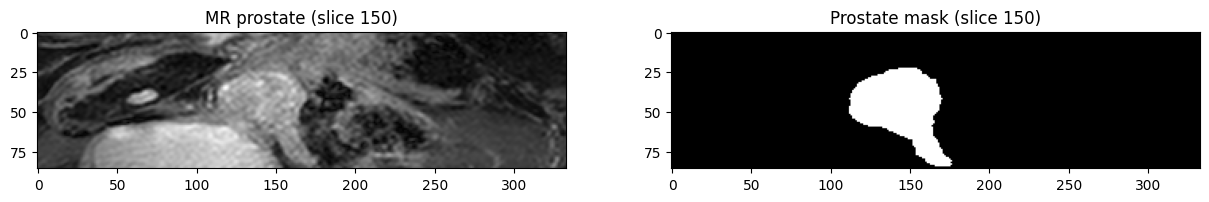

In [3]:
# Load example of patient data
mr_example = iio.imread(MR_TRAIN_PATHS[0])
mask_example = iio.imread(MASK_TRAIN_PATHS[0])

# Plot example of patient data
slice = 150
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(mr_example[:,:,slice], cmap="gray")
ax[0].set_title(f"MR prostate (slice {slice})")
ax[1].imshow(mask_example[:,:,slice], cmap="gray")
ax[1].set_title(f"Prostate mask (slice {slice})");

## Augmented Training Data
**The function `generate_aug_data` can be called to generate the augmented data**. If the augmented images are already generated, the image paths can be loaded directly in the next code block.

In [ ]:
def generate_aug_data(MR_PATHS, MASK_PATHS):
    """Generates augmented data images and saves them in right folder.
    
    parameters
    MR_PATHS: list of paths to patient MR images,
    MASK_PATHS: list of paths to patient mask images.
    
    returns
    aug_mr_train_paths: list of paths to augmented patient MR images
    aug_mask_train_paths: list of paths to augmented patient mask images
    """
    aug_mr_train_paths = []
    aug_mask_train_paths = []
    for idx in range(len(MR_PATHS)):
        # Find paths to mr image and mask
        mr_path = MR_PATHS[idx]
        mask_path = MASK_PATHS[idx]

        # Random elastic deformation on both mr image and mask
        aug_mr_path, aug_mask_path = reldef(mr_path, mask_path)

        # Append paths in list
        aug_mr_train_paths.append(aug_mr_path)
        aug_mask_train_paths.append(aug_mask_path)

    return aug_mr_train_paths, aug_mask_train_paths

# Example usage
# AUG_MR_PATHS, AUG_MASK_PATHS = generate_aug_data(MR_PATHS, MASK_PATHS)

Set the variable `use_augment_data` to True if you want to run an experiment with augmented data. Set this variable to False if you want to run the baseline experiment without augmented data. Change the variable `augment_type` based on the type of augmentation used. An overview of the options is given below:
- Normalize: `norm`
- Random elastic deformation: `reldef`
- Random gamma: `rgam`
- Random rotation: `rot`
- Rescale: `rescale`

In [4]:
# Augmentation settings
use_augment_data = True
augment_type = "norm"

# Load all augmented MR images and augmented masks
if use_augment_data and (augment_type == "reldef" or augment_type == "rot" or augment_type == "rescale" or augment_type == "affine"):
    AUG_MR_PATHS = [os.path.join(BASE_PATH, f, f"mr_bffe_aug_{augment_type}.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')] 
    AUG_MASK_PATHS = [os.path.join(BASE_PATH, f, f"prostaat_aug_{augment_type}.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')]  

# Load all augmented MR images without augmented masks
if use_augment_data and (augment_type == "norm" or augment_type == "rgam"):
    AUG_MR_PATHS = [os.path.join(BASE_PATH, f, f"mr_bffe_aug_{augment_type}.mhd") for f in os.listdir(BASE_PATH) if not f.startswith('.')] 
    AUG_MASK_PATHS = MASK_TRAIN_PATHS

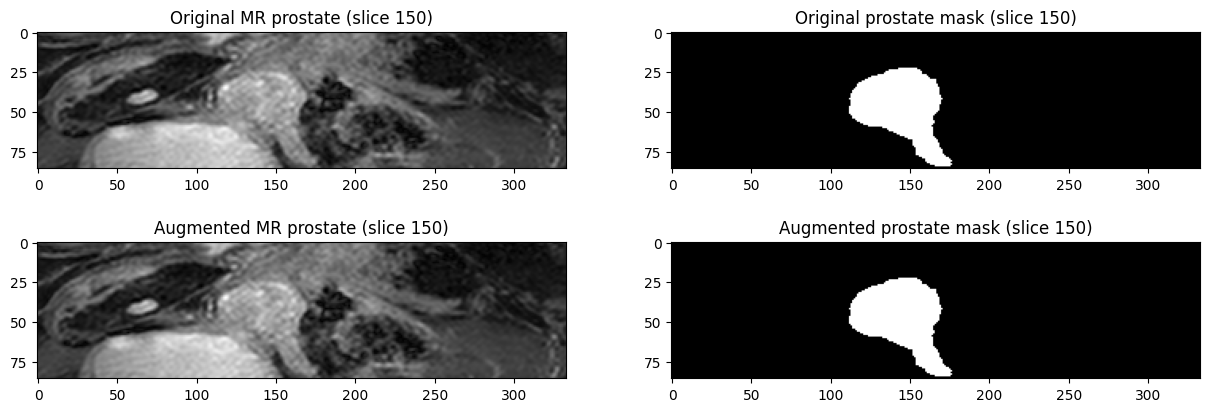

In [5]:
# Load example of augmented patient data
if use_augment_data:
    aug_mr_example = iio.imread(AUG_MR_PATHS[0])
    aug_mask_example = iio.imread(AUG_MASK_PATHS[0])

    # Plot example of augmented patient data
    slice = 150
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax = ax.flatten()
    ax[0].imshow(mr_example[:,:,slice], cmap="gray")
    ax[0].set_title(f"Original MR prostate (slice {slice})")
    ax[1].imshow(mask_example[:,:,slice], cmap="gray")
    ax[1].set_title(f"Original prostate mask (slice {slice})");
    ax[2].imshow(aug_mr_example[:,:,slice], cmap="gray")
    ax[2].set_title(f"Augmented MR prostate (slice {slice})")
    ax[3].imshow(aug_mask_example[:,:,slice], cmap="gray")
    ax[3].set_title(f"Augmented prostate mask (slice {slice})");

## Registration pipeline
In the code block below, a function is defined that performs the full baseline registration process. This includes a rigid registration step for a rough initial alignment, followed by a nonlinear registration step using BSplines. Here, the fixed image represents an image with unknown mask (validation data) and the moving image is an atlas image with known mask (training data). The deformation field obtained from this registration pipeline is applied to the mask of the moving image.

In [6]:
def registration_pipeline(fixed_image_path, moving_image_path, moving_mask_path):
    """
    """
    # Make a results directory if non exists
    if os.path.exists("results_baseline/rigid") is False:
        os.makedirs(os.path.join("results_baseline/rigid"))
    
    # Define a new elastix object 'el' with the correct path to elastix
    el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)

    # Execute the rigid registration step
    el.register(
        fixed_image=fixed_image_path,
        moving_image=moving_image_path,
        parameters=["parameters_baseline_rigid.txt"],
        output_dir="results_baseline/rigid"
    )   

    # Find result of rigid registration
    rigid_transformed_image_path = os.path.join('results_baseline/rigid', 'result.0.mhd')
    rigid_transform_path = os.path.join('results_baseline/rigid', 'TransformParameters.0.txt')

    # Make a new transformix object tr with the CORRECT PATH to transformix
    tr = elastix.TransformixInterface(parameters=rigid_transform_path, transformix_path=TRANSFORMIX_PATH)
    
    # Transform the mask with the transformation parameters
    rigid_transformed_mask_path = tr.transform_image(moving_mask_path, output_dir=os.path.join('results_baseline/rigid'))   

    # Make a results directory if non exists
    if os.path.exists("results_baseline/nonlinear") is False:
        os.makedirs(os.path.join("results_baseline/nonlinear"))

    # Execute the nonlinear registration step
    el.register(
        fixed_image=fixed_image_path,
        moving_image=rigid_transformed_image_path,
        parameters=["parameters_baseline_nonlinear.txt"],
        output_dir="results_baseline/nonlinear"
    )

    # Find result of nonlinear registration
    nonlinear_transform_path = os.path.join('results_baseline/nonlinear', 'TransformParameters.0.txt')

    # Make a new transformix object tr with the CORRECT PATH to transformix
    tr = elastix.TransformixInterface(parameters=nonlinear_transform_path, transformix_path=TRANSFORMIX_PATH)

    # Transform the mask with the transformation parameters
    nonlinear_transformed_mask_path = tr.transform_image(rigid_transformed_mask_path, output_dir=os.path.join('results_baseline/nonlinear'))

    return nonlinear_transformed_mask_path

The registration pipeline is called iteratively to create all altas segmentations for an image in the validation set. The masks are loaded into a numpy array and used in the following processing steps.

In [7]:
total_atlas = []

for test_idx in range(len(MR_TEST_PATHS)):
    # Loop over images in the testing set
    atlas_masks = []
    fixed_image_path = MR_TEST_PATHS[test_idx]

    for train_idx in range(len(MR_TRAIN_PATHS)):
        # Loop over images in the training set
        moving_image_path = MR_TRAIN_PATHS[train_idx]
        moving_mask_path = MASK_TRAIN_PATHS[train_idx]

        # Call registration pipeline and store deformed atlas masks
        new_atlas_mask_path = registration_pipeline(fixed_image_path, moving_image_path, moving_mask_path)
        atlas_masks.append(iio.imread(new_atlas_mask_path))

    if use_augment_data:
        for train_idx in range(len(AUG_MR_PATHS)):
            # Loop over images in the training set
            moving_image_path = AUG_MR_PATHS[train_idx]
            moving_mask_path = AUG_MASK_PATHS[train_idx]

            # Call registration pipeline and store deformed atlas masks
            new_atlas_mask_path = registration_pipeline(fixed_image_path, moving_image_path, moving_mask_path)
            atlas_masks.append(iio.imread(new_atlas_mask_path))
    
    atlas_masks = np.array(atlas_masks)
    total_atlas.append(atlas_masks)

    print(f"Finished test sample {test_idx + 1}")

# Convert to numpy array
total_atlas = np.array(total_atlas)


C:/Users/20212059/Documents/CapitaSelecta\elastix-5.0.0-win64/elastix.exe -f ../ValidatieData\p137\mr_bffe.mhd -m ../DevelopmentData/DevelopmentData\p102\mr_bffe.mhd -p parameters_baseline_rigid.txt -out results_baseline/rigid
C:/Users/20212059/Documents/CapitaSelecta\elastix-5.0.0-win64/elastix.exe -f ../ValidatieData\p137\mr_bffe.mhd -m results_baseline/rigid\result.0.mhd -p parameters_baseline_nonlinear.txt -out results_baseline/nonlinear
C:/Users/20212059/Documents/CapitaSelecta\elastix-5.0.0-win64/elastix.exe -f ../ValidatieData\p137\mr_bffe.mhd -m ../DevelopmentData/DevelopmentData\p107\mr_bffe.mhd -p parameters_baseline_rigid.txt -out results_baseline/rigid
C:/Users/20212059/Documents/CapitaSelecta\elastix-5.0.0-win64/elastix.exe -f ../ValidatieData\p137\mr_bffe.mhd -m results_baseline/rigid\result.0.mhd -p parameters_baseline_nonlinear.txt -out results_baseline/nonlinear
C:/Users/20212059/Documents/CapitaSelecta\elastix-5.0.0-win64/elastix.exe -f ../ValidatieData\p137\mr_bffe.m

In [8]:

total_atlas.tofile('atlas.dat')

## Results
The following figure displays the original mask of the validation sample on top. The following images show the deformed masks based on the atlas images in the training set. It will show ten images if the baseline model experiment is run and 20 images if data augmentation is turned on.

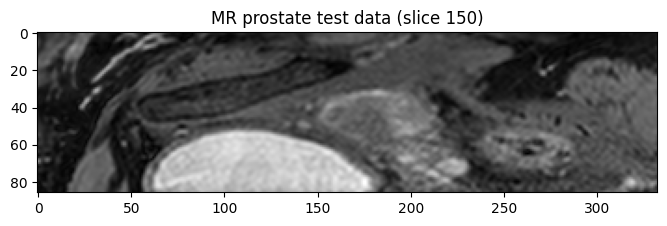

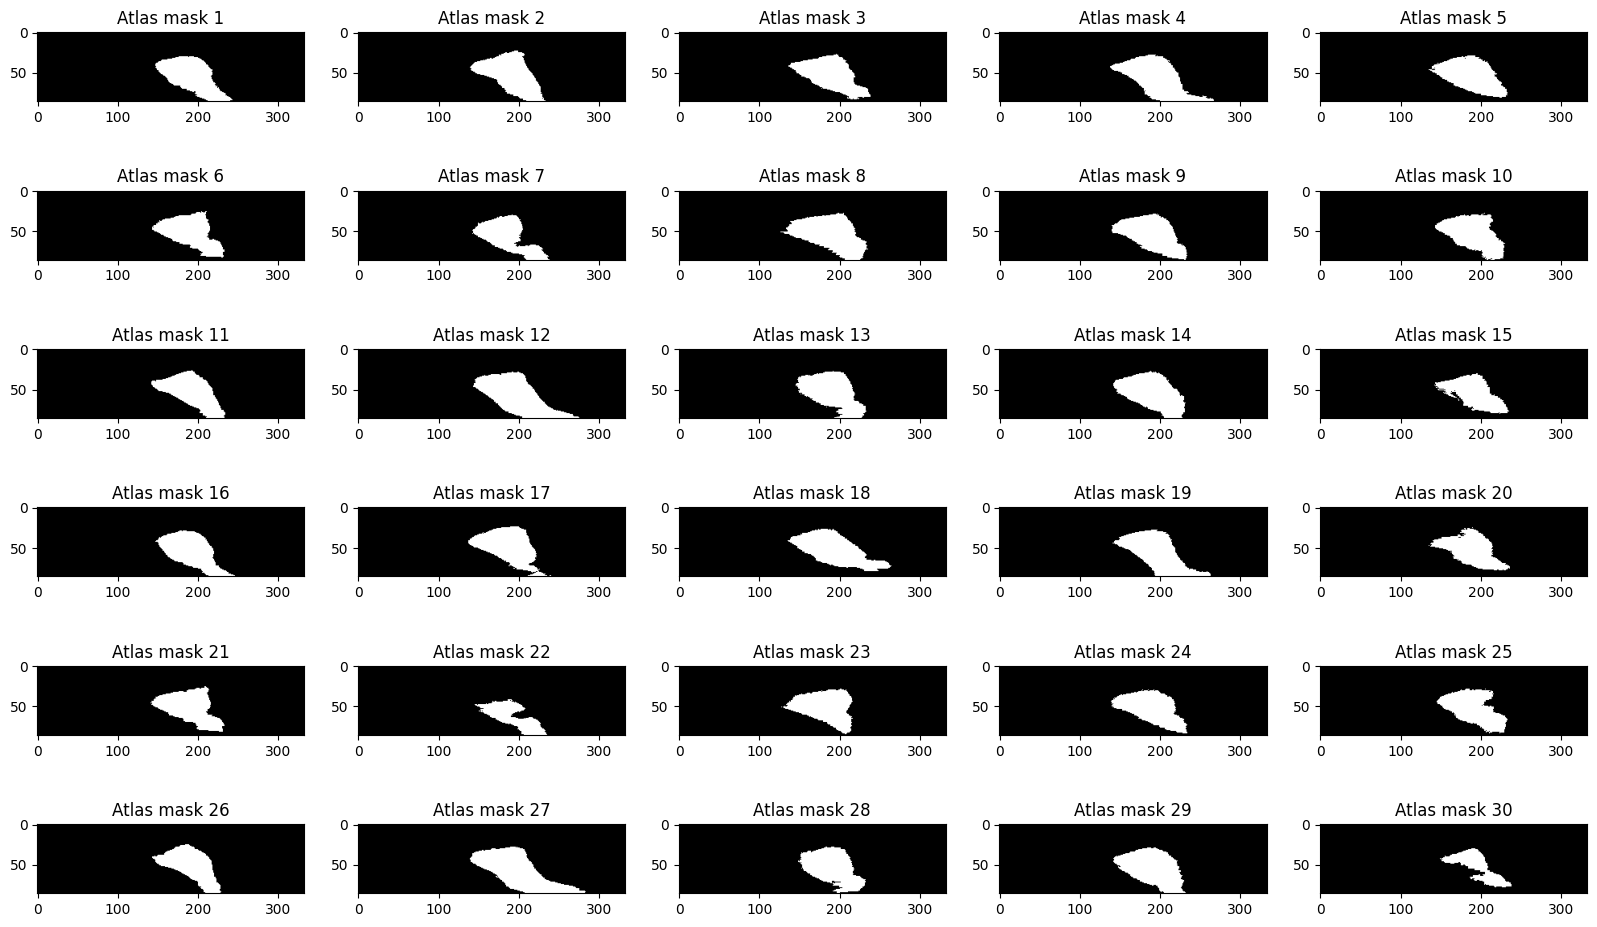

In [9]:
# Testing sample
slice = 150
test_idx = 0

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.imshow(iio.imread(MR_TEST_PATHS[test_idx])[:,:,slice], cmap="gray")
ax.set_title(f"MR prostate test data (slice {slice})");

# Atlas image segmentations
if use_augment_data:
    fig, ax = plt.subplots(6, 5, figsize=(20, 12))
else:
    fig, ax = plt.subplots(3, 5, figsize=(20, 6))
ax = ax.flatten()

for idx in range(len(atlas_masks)):
    ax[idx].imshow(total_atlas[test_idx][idx][:,:,slice], cmap="gray")
    ax[idx].set_title(f"Atlas mask {idx + 1}")

Combining the figures results in a new segmentation with values between 0 and 10 for the baseline experiment or 0 and 20 for augmented data experiments. A threshold can be chosen to create the finalized segmentation.

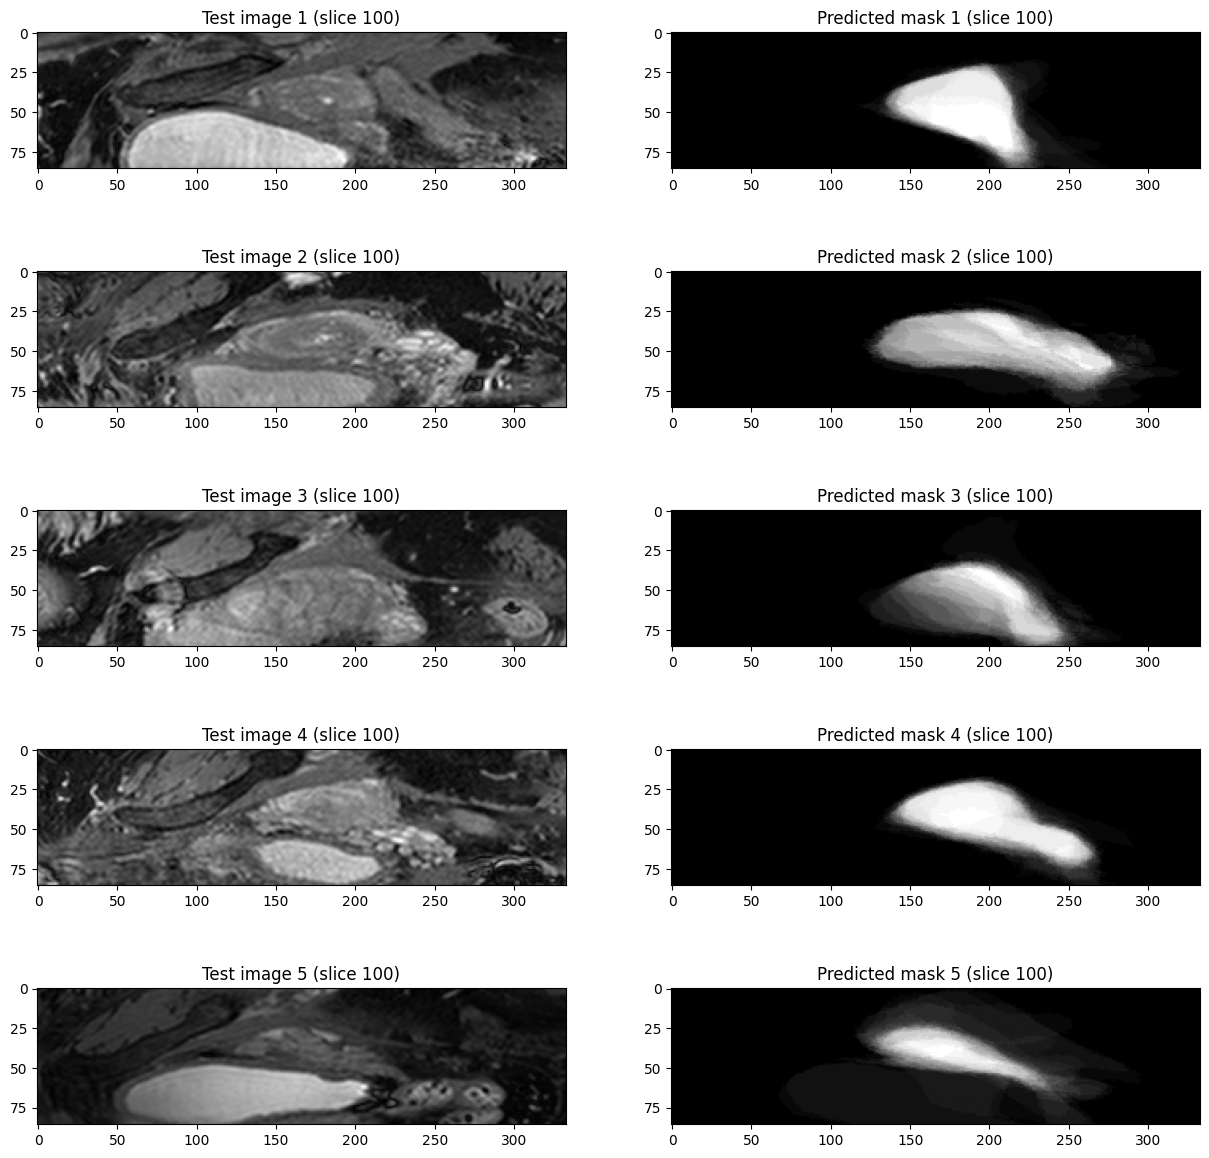

In [54]:
all_total_masks = []
for i in range(len(total_atlas)):
    # for mask in atlas_masks:
    total_mask = 0
    for mask in total_atlas[i]:
        total_mask += mask
    all_total_masks.append(total_mask)

slice = 100
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
for test_idx in range(len(MR_TEST_PATHS)):
    ax[test_idx,0].imshow(iio.imread(MR_TEST_PATHS[test_idx])[:,:,slice], cmap="gray")
    ax[test_idx,0].set_title(f"Test image {test_idx+1} (slice {slice})")
    ax[test_idx,1].imshow(all_total_masks[test_idx][:,:,slice], cmap="gray")
    ax[test_idx,1].set_title(f"Predicted mask {test_idx+1} (slice {slice})");

In [62]:
all_total_masks_binary = []
for mask in all_total_masks:
    all_total_masks_binary.append(mask > 15)


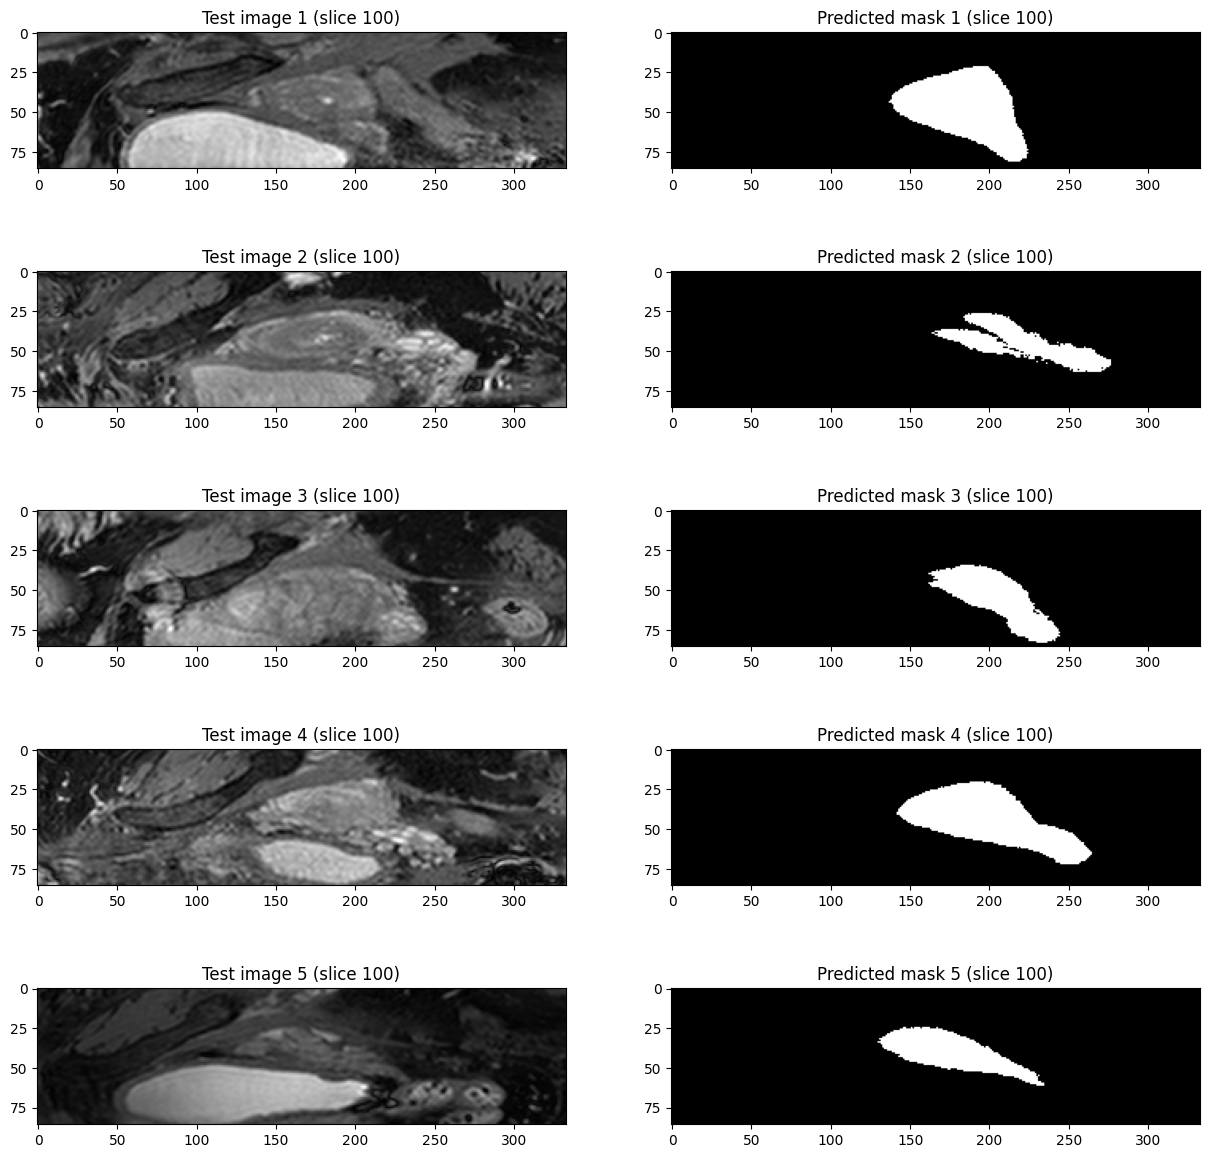

In [63]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
for test_idx in range(len(MR_TEST_PATHS)):
    ax[test_idx,0].imshow(iio.imread(MR_TEST_PATHS[test_idx])[:,:,slice], cmap="gray")
    ax[test_idx,0].set_title(f"Test image {test_idx+1} (slice {slice})")
    ax[test_idx,1].imshow(all_total_masks_binary[test_idx][:,:,slice], cmap="gray")
    ax[test_idx,1].set_title(f"Predicted mask {test_idx+1} (slice {slice})");

In [64]:
result_path = "../Results"
filenames = os.listdir(BASE_TEST_PATH)
for index, mask in enumerate(all_total_masks_binary):
    filename = filenames[index]
    if not os.path.exists(result_path+"/"+filename):
        os.makedirs(result_path+"/"+filename)
    path = result_path+"/"+filename+"/prostaat.mhd"
    mask = mask.astype(int)
    img = sitk.GetImageFromArray(mask)
    sitk.WriteImage(img, path)

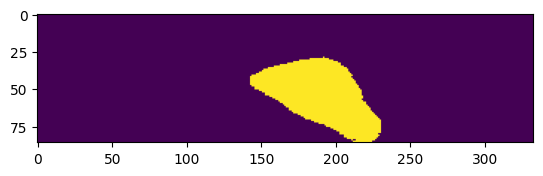

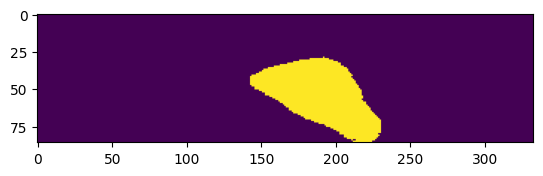

In [65]:
img = sitk.ReadImage("../Results/p137/prostaat.mhd")
img = sitk.GetArrayFromImage(img)
plt.imshow(img[:,:,150])